    Grigoriou Stergios 9564             grigster@ece.auth.gr  
Neural Networks-Deep Learning 
        1st Assignment
            2023

Conclusions will be discussed here instead of a seperate report. Above each code block there is a small description of what it produces and what were the results when I ran it.
First of all, the dataset I chose for the assignment is cifar-10. The code provides the option to load it from a local directory or download it through keras. It is a dataset of
50000 observations for the train set and 10000 for the test set, that are divided in 10 distinct classes. 
There is code and evaluations for: a fully connected MLP with 2 hidden layers with 512 and 256 nodes each, (FULL)
                                 : a not fully connected MLP with the same layers,(NOT-FULL)
                                 : a network consisting of 2 convolutional layers with 96 and 192 filters each, 1 not fully connected layer with 256 nodes and 1024 connections,1 
                                    fully conected layer with 256 nodes(CNN)
    For all the hidden layers the activation function is the rectified linear unit, and all models end with a softmax output layer of 10 fully connected nodes classifying the input with
one-hot encoding.
    There is also code that trains and evaluates the Nearest Neighbor,3-Nearest Neighbours and Nearest Centroid models. (Training on the train set, evaluation on the test set).
The models in terms of accuracy on the test set are sorted CNN>FULL>NOT-FULL>1-NN>3-NN>NC (71.42>57.76>51.99>35.39>33.03>27.74)
    In general for the mlp models, at start, I tried to narrow down on the learning rate and the moment that would start to overfit around 20 epochs. Thus, the models that 
I experiment with are not that deep (the best fully connected model I came with has 3 layers). For this estimation I used a 4 layer fully connected model (1024-256-64-10). After
arriving at some values (0.02 and 0.6), I did a grid search on various combinations  of nodes up to 8 layers (either all layers the same or scaling down). In the end I came up with
the best fully connected model being the model that has 3 layers (512-256-10) with learning rate of 0.008, moment 0.6 and the loss function being cross-entropy. In general cross-
entropy was really helpful on faster converging models, at least that is what I observed. The last step was regularizing the weights. At first I used L2 norm penalty, but I found 
that batch_normalization at the start of the model and dropout layer after each dense layer was performing better (at least at these low performing models). I did one more grid 
search and found that the better validation test accuracy was with dropout probabilities 0.4 and 0.2 after the 2 hidden layers. 
    After that I came up with an idea of reducing the connections between the layers and this is the second model (NOT_FULL), where each node in a layer is only connected to a
 specific number of successive nodes of the input layer. To be honest I didn't perform the same amount of tests, rather I just used the existing architecture and just tweaked it
 a little.
    At last, I tried training a convolutional network. After some experimentation with 2 convolutional layers and one or two fully connected layers, the best model I came up with
 has 2 convolutional layers, each followed by a downsampling layer, and then a 256-node fully connected layer leading to the 10-node softmax.
    In terms of training time the models are sorted NC>1-NN>3-NN>FUll>NOT-FULL>CNN. In general the MLPs where all able to achieve >95% accuracy on the train sample given enough 
 training time, but to avoid overfitting after considering the learning curves I was ending the training early. 
    To conclude, the MLPs where all able to have a meaningful classification in contrast to the 3 neighbourhood models. Meaning the most wrong classifications as it can be seen from
 the confusion matrices where among similar objects (ships-planes, car-truck,animals).

In [1]:
#In this block I import the necessary packages and define all the functions and classes I'll be using

import os
import tensorflow as tf
import numpy as np
from sklearn import metrics as mt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
import pickle
import keras.backend
import time
import pandas as pd


def unpickle(file):
    #This function turns pickle into dict, file is the file's path.
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='latin1')
    #batch is the dict containing the corresponding batch's data
    return batch


def load_data(path):
    #path is the path of the folder that contains cifar-10 uncompressed data files suitable for python
    #data contains the image data of the batch
    data = []
    #labels contains the corresponding to data labels
    labels = []
    metadata = unpickle(os.path.join(path,'batches.meta'))
    label_names = metadata['label_names']
    m = metadata['num_vis']
    n = metadata['num_cases_per_batch']
    #loading all 5 batches
    for i in range(1,6):
       filepath = os.path.join(path,'data_batch_%d' % i)
       temp = unpickle(filepath)
       data.append(np.reshape(temp['data'],(n,m)))
       labels.append(np.array(temp['labels']))
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    #loading the test data
    temp = unpickle(os.path.join(path,'test_batch'))
    test_data = np.reshape(temp['data'],(n,m))
    test_labels = np.array(temp['labels'])
    return data,labels,test_data,test_labels,label_names


def learning_curves(hist_obj,title_str='some model',saving=False,saving_path='',metric_name='categorical_accuracy',loss_name='cross entropy'):
    #This function is used to plot/save the learning_curves of the various mlp models that where trained
    #It take as input: a tf.keras.callbacks.History() object 
    #                : the tile of the model 
    #                : a logical value that determines if the plot will also be saved
    #                : the saving directory 
    #                : the name of the metric we want to plot. (must be in the list of the metrics that were calculated during the creation of the object)
    #                : the name of the loss function we want to plot. 
    train_lss = hist_obj.history['loss']
    val_lss = hist_obj.history['val_loss']
    train_metric = hist_obj.history[metric_name]
    val_metric = hist_obj.history['val_'+metric_name]
    epochs = np.linspace(1,len(train_lss),len(train_lss))
    plt.plot(epochs,train_lss,label='Training')
    plt.plot(epochs,val_lss,label='Validation')
    plt.xlabel('epochs')
    plt.ylabel(loss_name)
    plt.legend()
    plt.title('Loss curve of '+title_str)
    if saving:
        plt.savefig(os.path.join(saving_path,'loss_curve_of'+title_str+'.csv'))
    plt.show()
    plt.plot(epochs,train_metric,label='Training')
    plt.plot(epochs,val_metric,label='Validation')
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('Metric curve of '+title_str)
    if saving:
        plt.savefig(os.path.join(saving_path,'metric_curve_of'+title_str+'.csv'))
    plt.show()


def pruning_the_dense(inputs,outputs,connections):
    #This fucntion calculates a mask that keeps only 'connections' number of weights between input layer and output layer, in a specific way.
    #e.g. for (10,5,6) the mask is this: (each output node is connected with 6 different  nodes of the input) 
    #| [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] |T (T for transpose)
    #| [0. 1. 1. 1. 1. 1. 1. 0. 0. 0.] |
    #| [0. 0. 1. 1. 1. 1. 1. 1. 0. 0.] |
    #| [0. 0. 0. 1. 1. 1. 1. 1. 1. 0.] |
    #| [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] |
    con_nodes = tf.concat([tf.ones((1,connections)),tf.zeros((1,inputs-connections))],1)
    step = int(min((inputs/outputs)-0.5,(inputs/connections)))
    mask = con_nodes
    for col in range(outputs-1):
        mask = tf.concat([mask,tf.roll(con_nodes,step*(col+1),1)],0)
    return tf.transpose(mask)

    
class Sparse(tf.keras.layers.Dense):
    #A custom keras layer that uses the pruning_the_dense function in order to keep only some weights. (Not the most delicate approach since in terms of computational
    #complexity is the same as training a fully connected layer. But is useful in orer to calculate the performance in terms of loss/metric of a not fully connected model)
    def __init__(self, units=256,connections = 16):
        self.units = units
        self.connections = connections
        super(Sparse,self).__init__(units,activation="relu",kernel_initializer='glorot_normal')
        
    def call(self, inputs):
        prune_mat = pruning_the_dense(inputs.shape[-1],self.units,self.connections)
        output = keras.backend.dot(inputs,self.kernel*prune_mat) + self.bias
        if self.use_bias:
            output = keras.backend.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
def seq_model(layer_arg=(512,0.4,256,0.2),layer_type=('D','Do','D','Do'),L2pen=None,model_name='2_Hidden_Layer_Dense_with_Dropout'):
    #For more compact and repetitive model creation
    model_out = tf.keras.Sequential(name= model_name)
    model_out.add(tf.keras.layers.Input(shape=(3072,)))
    model_out.add(tf.keras.layers.BatchNormalization())
    for layer in range(len(layer_arg)):
        if layer_type[layer] == 'D':
            if L2pen is not None:
                model_out.add(tf.keras.layers.Dense(layer_arg[layer], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(L2pen)))
            else:
                model_out.add(tf.keras.layers.Dense(layer_arg[layer], activation="relu",kernel_initializer='glorot_normal'))
        elif layer_type[layer] == 'S':
            model_out.add(Sparse(layer_arg[layer][0],layer_arg[layer][1]))
        elif layer_type[layer] == 'Do':
            model_out.add(tf.keras.layers.Dropout(layer_arg[layer]))
        else:
            raise Exception("Supported layer types are Dense(D),Sparse(S),Dropout") 
    model_out.add(tf.keras.layers.Dense(10,activation='softmax'))
    return model_out


def train_model(Xs,ys,model_type,kN=0):
    #Xs and ys are the train set
    #model_type can be either 'NN' or 'nearest_centroid'
    #k is the k parameter (number of neighbours) for the k-NN model
    model_name = ''
    modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
    t = time.time()#for runtime estimation
    #fitting the model to the train data
    if model_type == 'NN':
        modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
        modele.fit(Xs,ys)
        t = time.time() - t
        model_name = ('%d-NN'% kN)
    elif model_type == 'nearest_centroid':
        modele = NearestCentroid()
        modele.fit(Xs, ys)
        t = time.time() - t
        model_name = 'Nearest Centroid'
    else:
        print('Wrong model_type input. Acceptable values\nare: "NN" or "nearest_centroid".')
    print('%s:'% model_name)
    print('Training time elapsed: %.2f ms.'%(1000*t))
    return modele,model_name


def evaluate_model(modele,Xs,ys,model_name,label_names):
    #model is the sklearn classification model object for evaluation
    #Xs ys are the validation or test data
    #model_name is the name of the model
    #Predicting the classes of the test Xs
    t = time.time()#for calculating prediction time
    y_hat = modele.predict(Xs)
    if len(y_hat.shape) > 1:
        y_hat = np.argmax(y_hat,1)
    t = time.time() - t
    print('Prediction time elapsed: %.2f ms.' % (1000 * t))
    #Calculating recall and precision class wise
    recall = mt.recall_score(ys, y_hat, average=None)
    precision = mt.precision_score(ys, y_hat, average=None)
    # Calculating class wise f1_score
    f1 = 2*recall*precision/(recall+precision)
    #Calculating average (macro) accuracy of the model
    accu = np.sum(np.equal(ys,y_hat))/len(ys)#or just the np.mean(recall)
    print('Accuracy: %.4f'% accu)
    df = np.vstack((recall,precision))
    df = np.vstack((df,f1))
    avrgs = np.zeros((3,1))
    avrgs[2] = np.mean(f1)
    avrgs[1] = np.mean(precision)
    avrgs[0] = np.mean(recall)
    df = np.hstack((df,avrgs))
    label_names = np.hstack((label_names,'average'))
    daf = pd.DataFrame(data=df,index=['recall','precision','f1'],columns=label_names)
    print(daf.to_string())
    print('\n\n')
    #Calculating and plotting the confusion matrix of the model on the val/test data
    cm = mt.confusion_matrix(ys, y_hat)
    disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names[0:10])
    disp.plot()
    plt.title(model_name)
    plt.show()
    return recall, precision, f1
    
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'#Surpressing some tensorflow warnings     

my_path = 'C:\cifar10'#Change this to the path where your cifar-10 data is stored or keep it '' in order to download it.


-Main part of the code starts here.-

In [2]:
#Loading Data.
if my_path == '':
    (X,y),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()
    label = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']
    X = tf.reshape(X,(50000,3072))
    X_test = tf.reshape(X_test,(50000,3072))
else:
    X,y,X_test,y_test,label = load_data(my_path)
    label[0] = 'plane'#for visual purposes
    label[1] = 'auto'
#Making the labels one-hots instead of integer
y = tf.one_hot(y,10)
y_test = tf.one_hot(y_test,10)
#uint8 -> float in the range of [0,1]
X = tf.convert_to_tensor(X/255.0,dtype=float)
X_test = tf.convert_to_tensor(X_test/255.0,dtype=float)

Epoch 1/57
500/500 [==============================] - 5s 7ms/step - loss: 1.9246 - categorical_accuracy: 0.3216 - val_loss: 1.6659 - val_categorical_accuracy: 0.4215
Epoch 2/57
500/500 [==============================] - 3s 6ms/step - loss: 1.7011 - categorical_accuracy: 0.3947 - val_loss: 1.5866 - val_categorical_accuracy: 0.4519
Epoch 3/57
500/500 [==============================] - 3s 6ms/step - loss: 1.6148 - categorical_accuracy: 0.4275 - val_loss: 1.5416 - val_categorical_accuracy: 0.4687
Epoch 4/57
500/500 [==============================] - 3s 6ms/step - loss: 1.5634 - categorical_accuracy: 0.4461 - val_loss: 1.5149 - val_categorical_accuracy: 0.4718
Epoch 5/57
500/500 [==============================] - 3s 6ms/step - loss: 1.5294 - categorical_accuracy: 0.4588 - val_loss: 1.4723 - val_categorical_accuracy: 0.4933
Epoch 6/57
500/500 [==============================] - 3s 6ms/step - loss: 1.4910 - categorical_accuracy: 0.4722 - val_loss: 1.4591 - val_categorical_accuracy: 0.4918
Epoc

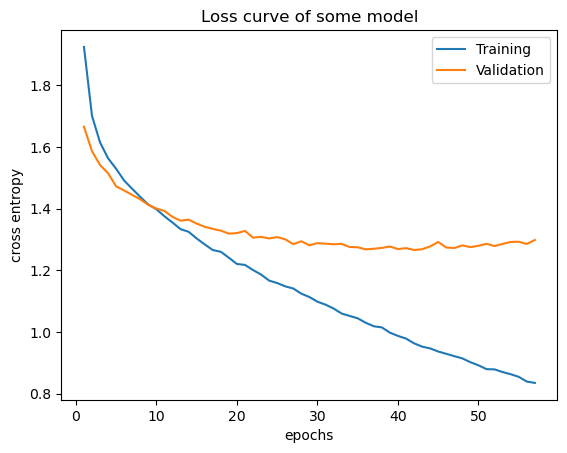

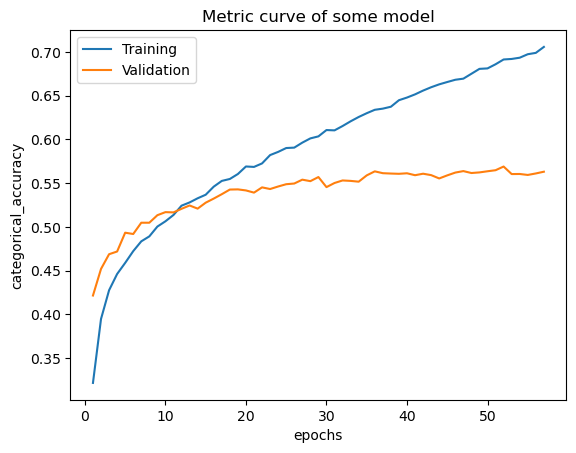

Epoch 1/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9916 - categorical_accuracy: 0.6560
Epoch 2/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9678 - categorical_accuracy: 0.6651
Epoch 3/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9514 - categorical_accuracy: 0.6717
Epoch 4/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9363 - categorical_accuracy: 0.6724
Epoch 5/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9241 - categorical_accuracy: 0.6780
Epoch 6/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9165 - categorical_accuracy: 0.6782
Epoch 7/57
625/625 [==============================] - 4s 6ms/step - loss: 0.9040 - categorical_accuracy: 0.6866
Epoch 8/57
625/625 [==============================] - 4s 6ms/step - loss: 0.8936 - categorical_accuracy: 0.6873
Epoch 9/57
625/625 [==============================] - 4s 6ms/step - loss: 0.8788 - categorical_accuracy:

[1.309386968612671, 0.5776000022888184]

In [69]:
#The best fully connected 3-Layer MLP I came up with (default on seq_model()), fitted for 57 epochs (just before the overfitting starts worsening the generalization) and then evaluated on test data
#The results for 2000 epochs are on the report
mfull = seq_model()
mfull.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.008,momentum=0.6),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()],
)
history = mfull.fit(X,y,verbose=1,batch_size=80,epochs=57,validation_split=0.2)
learning_curves(history)#(The plots can be seen on the report too.)
mfull.fit(X,y,batch_size=80,epochs=57)#See report
mfull.evaluate(X_test,y_test,verbose=1)#Evaluated at [cross entropy, accuracy] == [1.309386968612671, 0.5776000022888184]  on unseen test data.

313/313 [==============================] - 1s 3ms/step
Prediction time elapsed: 1432.22 ms.
Accuracy: 0.5776
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.654000  0.693000  0.403000  0.370000  0.542000  0.463000  0.687000  0.617000  0.733000  0.614000  0.577600
precision  0.646245  0.699294  0.484375  0.397422  0.485663  0.474872  0.569652  0.687082  0.668796  0.651113  0.576451
f1         0.650099  0.696133  0.439956  0.383221  0.512287  0.468861  0.622847  0.650158  0.699427  0.632012  0.575500


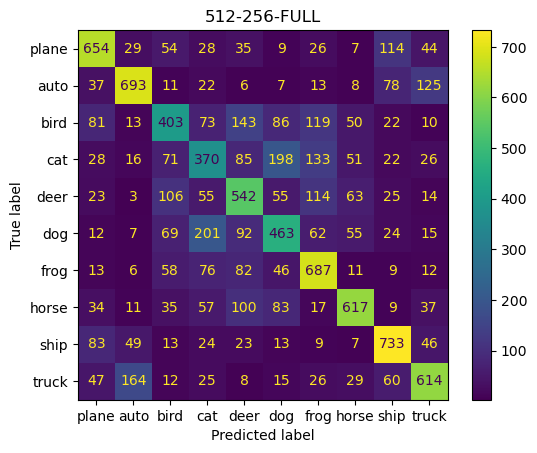

Nearest Centroid:
Training time elapsed: 402.36 ms.
Prediction time elapsed: 423.54 ms.
Accuracy: 0.2774
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.539000  0.186000  0.107000  0.056000  0.119000  0.286000  0.538000  0.166000  0.370000  0.407000  0.277400
precision  0.267361  0.283105  0.283069  0.265403  0.275463  0.268545  0.216499  0.266881  0.418079  0.325861  0.287027
f1         0.357427  0.224502  0.155298  0.092486  0.166201  0.276998  0.308752  0.204686  0.392573  0.361939  0.254086


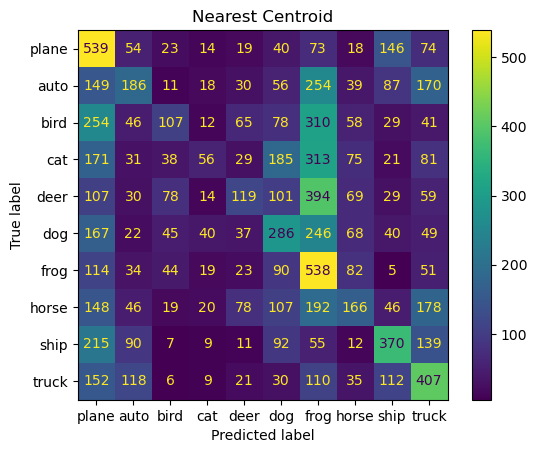

1-NN:
Training time elapsed: 102.30 ms.
Prediction time elapsed: 32151.98 ms.
Accuracy: 0.3539
              plane      auto      bird       cat      deer       dog      frog     horse     ship     truck   average
recall     0.485000  0.218000  0.384000  0.240000  0.457000  0.290000  0.353000  0.294000  0.61900  0.199000  0.353900
precision  0.423951  0.648810  0.242424  0.291616  0.249182  0.363409  0.328372  0.558935  0.39884  0.606707  0.411225
f1         0.452425  0.326347  0.297214  0.263302  0.322512  0.322581  0.340241  0.385321  0.48511  0.299699  0.349475


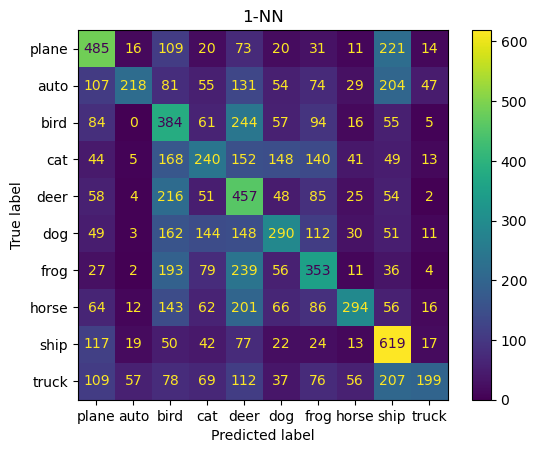

3-NN:
Training time elapsed: 103.73 ms.
Prediction time elapsed: 32688.82 ms.
Accuracy: 0.3303
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.573000  0.243000  0.450000  0.225000  0.436000  0.213000  0.229000  0.199000  0.612000  0.123000  0.330300
precision  0.320649  0.575829  0.201884  0.259815  0.251587  0.429435  0.361769  0.731618  0.439024  0.732143  0.430375
f1         0.411195  0.341772  0.278724  0.241158  0.319063  0.284759  0.280465  0.312893  0.511278  0.210616  0.319192


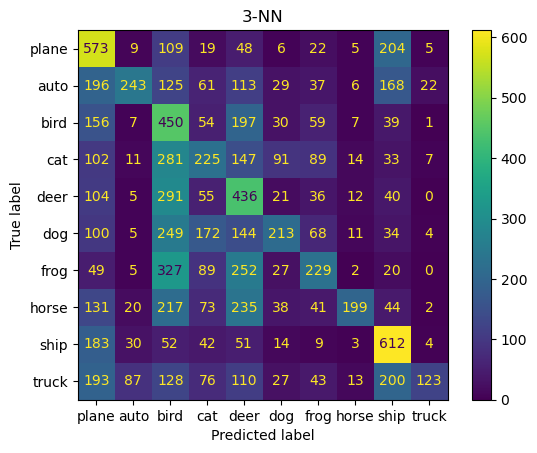

In [88]:
#Evaluating 512-256-10 Fully Connected on test set
p_full,r_full,f1_full = evaluate_model(mfull,X_test,np.argmax(y_test,1),'512-256-FULL',label)
#Training nearest_centroid on train set
cn,cn_name = train_model(X,np.argmax(y,1),'nearest_centroid')
#Evaluating nearest_centroid on test set
p_cn,r_cn,f1_cn = evaluate_model(cn,X_test,np.argmax(y_test,1),cn_name,label)
#Training 1-NN on train set
nn1,nn1_name = train_model(X,np.argmax(y,1),'NN',1)
#Evaluating 1-NN on test set
p_nn1,r_nn1,f1_nn1 = evaluate_model(nn1,X_test,np.argmax(y_test,1),nn1_name,label)
#Training 3-NN on train set
nn3,nn3_name = train_model(X,np.argmax(y,1),'NN',3)
#Evaluating 1-NN on test set
p_nn3,r_nn3,f1_nn3 = evaluate_model(nn3,X_test,np.argmax(y_test,1),nn3_name,label)


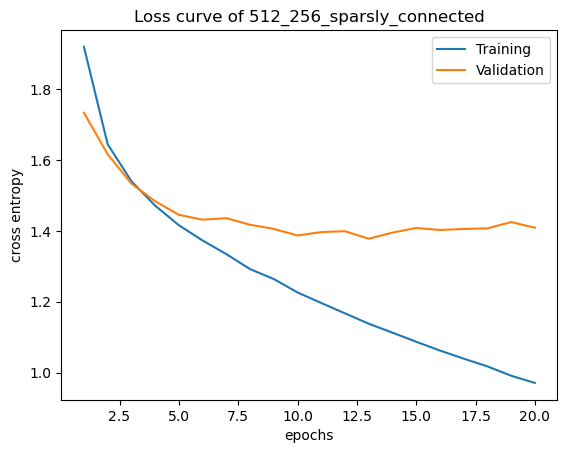

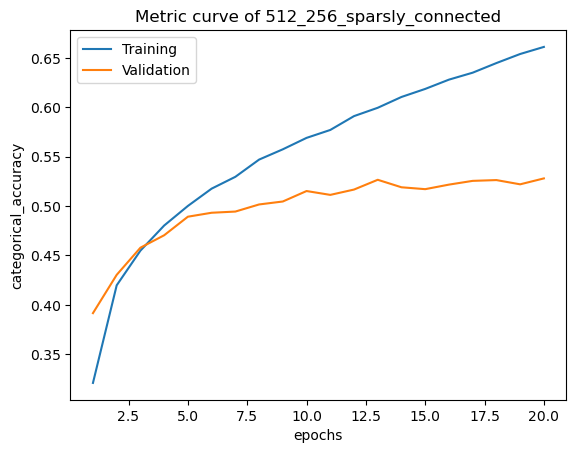

313/313 [==============================] - 6s 2ms/step
Prediction time elapsed: 6163.37 ms.
Accuracy: 0.5196
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.605000  0.628000  0.433000  0.419000  0.454000  0.435000  0.535000  0.490000  0.643000  0.554000  0.519600
precision  0.579502  0.584730  0.412381  0.334932  0.432793  0.433267  0.593126  0.689170  0.646881  0.601520  0.530830
f1         0.591977  0.605593  0.422439  0.372279  0.443143  0.434132  0.562566  0.572764  0.644935  0.576783  0.522661



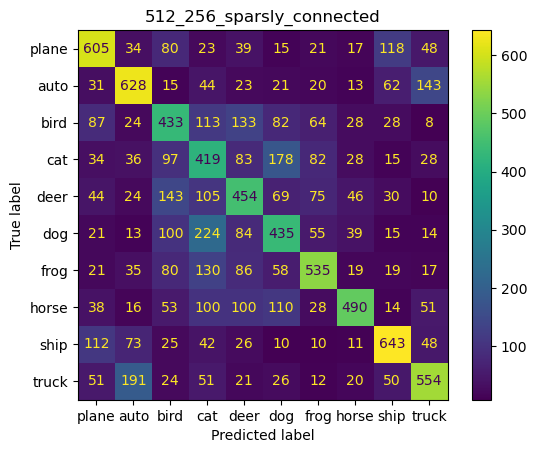

In [27]:
#Sparsely (still sequential though) connected model using the custom Sparse Layer
m = seq_model(((512,256),(256,128)),('S','S'),model_name='512_256_sparsly_connected')
m.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.02,momentum=0.6),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()],
)
history = m.fit(X,y,verbose=0,batch_size=80,epochs=20,validation_split=0.2)
learning_curves(history,title_str=m.name)
m.fit(X,y,verbose=0,batch_size=80,epochs=20)
p_m,r_m,f1_m = evaluate_model(m,X_test,np.argmax(y_test,1),m.name,label)#Accuracy: 0.5199

In [21]:
Xim = tf.reshape(X,(50000,32,32,3))
Xim_test = tf.reshape(X_test,(10000,32,32,3))
cnn = tf.keras.Sequential()
cnn.add(tf.keras.Input(shape=(32,32,3)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Conv2D(96,(3,3),activation='relu',padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(2,2))
cnn.add(tf.keras.layers.Conv2D(192,(3,3),activation='relu',padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(2,2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dense(256,activation='relu',kernel_initializer='glorot_normal'))
cnn.add(tf.keras.layers.Dense(10,activation='softmax'))
cnn.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.008,momentum=0.6),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()],)
cnn.summary()
cnn_history = cnn.fit(Xim,y,verbose=1,batch_size=80,epochs=13,validation_split=0.2)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_30 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 96)        2688      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 192)       166080    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 8, 8, 192)        0         
 g2D)                                                            
                                                     

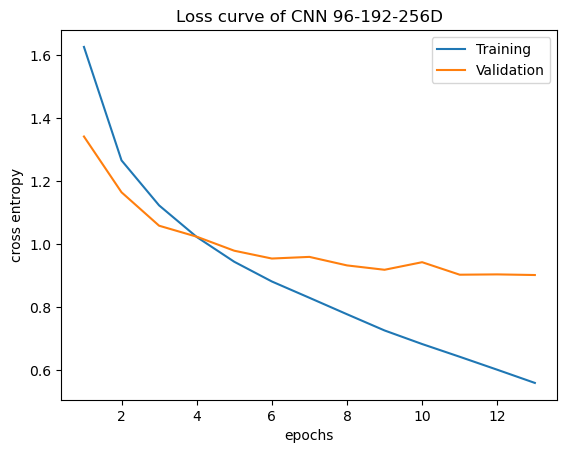

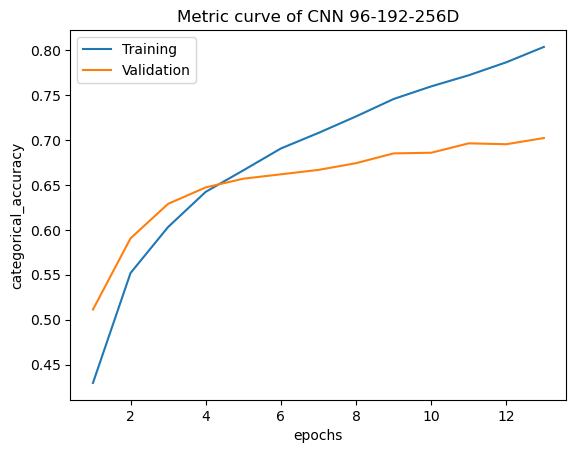

313/313 [==============================] - 1s 4ms/step
Prediction time elapsed: 1432.18 ms.
Accuracy: 0.7141
              plane      auto     bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.804000  0.821000  0.57300  0.506000  0.636000  0.592000  0.814000  0.729000  0.859000  0.807000  0.714100
precision  0.735590  0.782650  0.64819  0.525988  0.703540  0.621849  0.730700  0.805525  0.826756  0.734973  0.711576
f1         0.768275  0.801367  0.60828  0.515800  0.668067  0.606557  0.770104  0.765354  0.842570  0.769304  0.711568


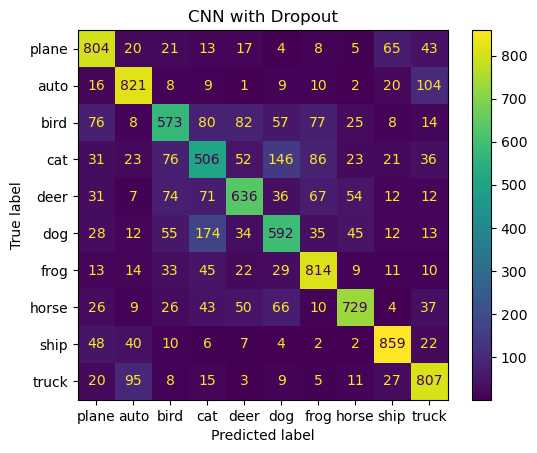

In [26]:
learning_curves(cnn_history,title_str='CNN 96-192-256D')#With 0.5 dropout and downsampling after each convolutional layer
h = cnn.fit(Xim,y,verbose=0,batch_size=80,epochs=13)
p_cnn,r_cnn,f1_cnn = evaluate_model(cnn,Xim_test,np.argmax(y_test,1),'CNN with Dropout',label)#Accuracy: 0.7141

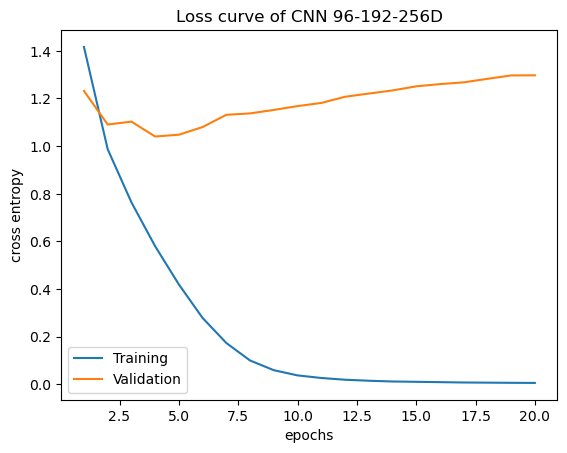

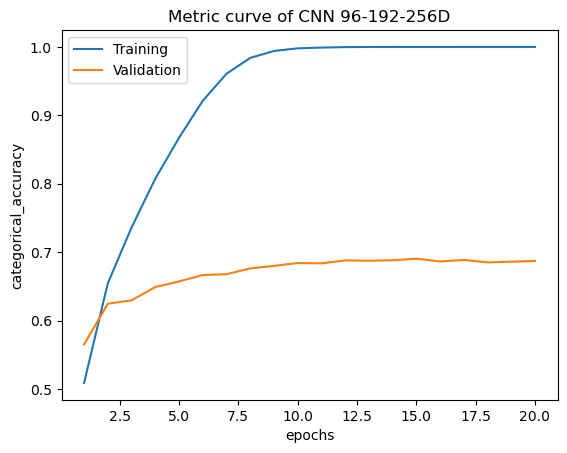

In [14]:
learning_curves(cnn_history,title_str='CNN 96-192-256D')#Without any dropout just downsampling after each convolutional layer, just to demonstrate overfitting 
#(accuracy on train set is 100%.

-Main part of the code ends here.-

Starting below are some code blocks that correspond to the tests/thought process that yielded the parameters of the fully connected model. 
I'm going to call them 'Extra block #' and their usage is clarified by the report.

Extra block 1
After some initial experimentation (basically trained 9 fully connected arbitarily selected models with learning rate of 0.001 with moment 0.5 for 2000 epochs),
I had a starting architecture of 3 hidden layers with 1024, 256 and 32 neurons respectively. 
For this architecture I did a grid search for the best (or at least feasible) learning rate, moment and loss function for 20 epochs (The goal was to achieve much faster 
convergence). 
After this search I chose lr = 0.02 and moment = 0.6. Below is the code with the best model and not the original search which was with h and mom having the values 
on the comments and the seq_model((1024,256,32),('D','D','D')).

In [48]:
#Extra block 1
tex_path = ''

h = [0.02,0.008,0.1]#np.linspace(0.1,0.001,10)
mom = [0.8,0.6,0.2] #np.linspace(0.9,0.1,10)
h_ind = np.zeros(5)
mom_ind = np.zeros(5)
h_ind_mse = np.zeros(5)
mom_ind_mse = np.zeros(5)
acc = np.zeros(5)
acc1 = np.zeros(5)
#It's a search for the 5 best model depending on validation accuracy for MSE and Cross Entropy. The data were not produced with cross validation but with simple one time in a 8K
#sample fit and validation on the rest 2K of the first batch.
for i in range(len(h)):
    for j in range(len(mom)):
        #Creating 2 models one with cross entorpy and one with MSE as the loss function. Then training them with the corresponding learning rate and moment parameters.
        amodel = seq_model((512,0.4,256,0.2),('D','Do','D','Do'),model_name='512_256_full_Drop')
        amodel.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=h[i],momentum=mom[j]),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()],)
        searching_for_h_and_mom = amodel.fit(X[0:10000],y[0:10000],verbose=0,batch_size=80,epochs=20,validation_split=0.2)
        xent = searching_for_h_and_mom.history['val_categorical_accuracy']
        amodel = seq_model((512,0.4,256,0.2),('D','Do','D','Do'),model_name='512_256_full_Drop')
        amodel.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=h[i],momentum=mom[j]),loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.CategoricalAccuracy()],)
        searching_for_h_and_mom = amodel.fit(X[0:10000],y[0:10000],verbose=0,batch_size=80,epochs=20,validation_split=0.2)
        mse =  searching_for_h_and_mom.history['val_categorical_accuracy']
        temp = np.average(xent[15:20])
        temp1 = np.average(mse[15:20])
        #If it is bigger than the 5 biggest keep it
        for k in range(len(acc)):
            if temp > acc[k]:
                acc[k] = temp
                ind = np.argsort(acc)
                acc = acc[ind]
                h_ind[k] = i
                h_ind = h_ind[ind]
                mom_ind[k] = j
                mom_ind = mom_ind[ind]
                break
        for k in range(len(acc1)):
            if temp1 > acc1[k]:
                acc1[k] = temp1
                ind = np.argsort(acc1)
                acc1 = acc1[ind]
                h_ind_mse[k] = i
                h_ind_mse = h_ind_mse[ind]
                mom_ind_mse[k] = j
                mom_ind_mse = mom_ind_mse[ind]
                break
#Print the 5 best models based on mean validation accuracy across epochs 16 to 20
for i in range(0,5):
    print('xent: %.4f_%.4f  acc = %f' % (h[int(h_ind[i])],mom[int(mom_ind[i])],acc[i]))
for i in range(0,5):
    print('mse: %.4f_%.4f  acc = %f' % (h[int(h_ind_mse[i])],mom[int(mom_ind_mse[i])],acc1[i]))

xent: 0.0080_0.2000  acc = 0.463800
xent: 0.0200_0.2000  acc = 0.472500
xent: 0.0200_0.6000  acc = 0.474500
xent: 0.0080_0.6000  acc = 0.474600
xent: 0.0080_0.8000  acc = 0.474800
mse: 0.0200_0.6000  acc = 0.394700
mse: 0.0200_0.8000  acc = 0.426400
mse: 0.1000_0.2000  acc = 0.430700
mse: 0.1000_0.6000  acc = 0.445900
mse: 0.1000_0.8000  acc = 0.457200


In the block below I performed a 5-fold validation (not 5-fold cross validation) using all the available batches of the dataset once each. So again the result is a rough
estimation of what might be a good fully connected model. I searched models with 2 to 8 layers (counting the out layer) with 1024,256,64 or 16 neurons on each layer or a 
decreasing combination of powers of 2 e.g.(1024-256-64). In order to not skew the results with just 1 learning rate I searched for 3 learning rates with moment 0.6, and I
used L2 regularization with 3 different penalty values as well. The best results according to validation accuracy at epochs 16 to 20 averaged through the 5 folds, were 
given by models with either 2 or 3 layers eg(1024,1024),(1024,256),(256,256,256),(1024,256,64),(1024,1024,1024). But beacuse the trple 256 was better than the triple 1024 
I was focused on the smaller models on the next test. The best models all shared lr= 0.008 and L2 penalty of 0.01. So I used this values from now on.

In [132]:
#Extra block 2
N = [1024,256,64,16]
N5 = [1024,256,64,32,16]
N6 = [1024,512,128,64,32,16]
N7 = [1024,512,256,128,64,32,16]
l2 = [0.01,0.005,0.001]
lr = [0.08,0.02,0.008]
val_acc = np.zeros((7,5,3,3,5))
#5 batch validation instead of cross_val since I want to train it on the whole dataset in the end
for i in range(0,5):
    X_train = X[i*10000:(i+1)*10000]
    y_train = y[i*10000:(i+1)*10000]
    for h_value in range(len(lr)):
        for losspen in range(len(l2)):
            for j in range(len(N)):
                for number_of_layers in range(1,8):
                    model = tf.keras.models.Sequential()
                    model.add(tf.keras.Input(shape=(3072,)))
                    model.add(tf.keras.layers.BatchNormalization())
                    for k in range(0,number_of_layers):
                        model.add(tf.keras.layers.Dense(N[j], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(l2[losspen])))
                    model.add(tf.keras.layers.Dense(10, activation="softmax"))
                    model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=lr[h_value],momentum=0.6),loss=tf.keras.losses.CategoricalCrossentropy(),
                                  metrics=[tf.keras.metrics.CategoricalAccuracy()],)
                    loopin = 20
                    print('%d_%d' % (N[j],number_of_layers))
                    history = model.fit(X_train,y_train,verbose=0,batch_size=80,epochs=loopin,validation_split=0.2)
                    val_acc[number_of_layers-1][j][h_value][losspen][i] = np.average(history.history['val_categorical_accuracy'][15:20])
            for number_of_layers in range(2,8):
                model = tf.keras.models.Sequential()
                model.add(tf.keras.Input(shape=(3072,)))
                model.add(tf.keras.layers.BatchNormalization())
                for k in range(0,number_of_layers):
                    if number_of_layers < 5:
                        model.add(tf.keras.layers.Dense(N[k], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(l2[losspen])))
                    elif number_of_layers == 5:
                        model.add(tf.keras.layers.Dense(N5[k], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(l2[losspen])))
                    elif number_of_layers == 6:
                        model.add(tf.keras.layers.Dense(N6[k], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(l2[losspen])))
                    elif number_of_layers == 7:
                        model.add(tf.keras.layers.Dense(N7[k], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(l2[losspen])))
                model.add(tf.keras.layers.Dense(10, activation="softmax"))
                model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=lr[h_value],momentum=0.6),loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()],
                )
                loopin = 20
                print('%d_%d' % (314,number_of_layers))
                history = model.fit(X_train,y_train,verbose=0,batch_size=80,epochs=loopin,validation_split=0.2)
                val_acc[number_of_layers-1][4][h_value][losspen][i] = np.average(history.history['val_categorical_accuracy'][15:20])
                
cross_val = np.average(val_acc,4)
indices = np.argsort(cross_val,axis=None)
max_five = indices[-5:]
max_five = np.unravel_index(max_five,cross_val.shape)
print(cross_val[max_five])
print('The best 10 models based on average accuracy\ntrained on 5 different batches are:\n')
for i  in range(1,6):
    if max_five[1][-i] < 4:
        widest_layer = N[max_five[1][-i]]
        net_type = 'All_same'
    else:
        widest_layer = N[0]
        net_type = 'pyramid'
    print('%d Hidden Layers: %d Number of neurons in the first layer: %d Type: %s LR: %.3f L2_pen: %.3f' % (i,max_five[0][-i]+1,widest_layer,net_type,lr[max_five[2][-i]],l2[max_five[3][-i]]))  
            

1024_1
Epoch 1/20
100/100 - 2s - loss: 13.9623 - categorical_accuracy: 0.2855 - val_loss: 8.9793 - val_categorical_accuracy: 0.3035 - 2s/epoch - 16ms/step
Epoch 2/20
100/100 - 1s - loss: 6.6994 - categorical_accuracy: 0.3881 - val_loss: 5.0268 - val_categorical_accuracy: 0.3870 - 716ms/epoch - 7ms/step
Epoch 3/20
100/100 - 1s - loss: 4.0401 - categorical_accuracy: 0.4164 - val_loss: 3.3594 - val_categorical_accuracy: 0.3755 - 712ms/epoch - 7ms/step
Epoch 4/20
100/100 - 1s - loss: 2.8704 - categorical_accuracy: 0.4244 - val_loss: 2.6821 - val_categorical_accuracy: 0.3885 - 672ms/epoch - 7ms/step
Epoch 5/20
100/100 - 1s - loss: 2.3360 - categorical_accuracy: 0.4425 - val_loss: 2.2854 - val_categorical_accuracy: 0.3915 - 684ms/epoch - 7ms/step
Epoch 6/20
100/100 - 1s - loss: 2.0928 - categorical_accuracy: 0.4572 - val_loss: 2.3317 - val_categorical_accuracy: 0.3830 - 681ms/epoch - 7ms/step
Epoch 7/20
100/100 - 1s - loss: 2.0127 - categorical_accuracy: 0.4608 - val_loss: 2.3064 - val_categ

After the search on block 2 I focused the search on 2 or 3 hidden layer mlps. Again I used each batch of the dataset once. I trained with LR =0.008, L2 penalty = 0.01 and 
moment 0.6. For each model again I averaged the validation accuracy of the last 5 epochs of the training.

In [210]:
#Extra block 3
LR = 0.008
L2 = 0.01
N = ((1024,256),(256,256,256),(1024,256,64),(256,128,32),(512,128,32),(256,128),(512,128),(256,128,64),(512,256))
a = np.zeros((len(N),5))
for k in range(5):
    X_train = X[k*10000:(k+1)*10000]
    y_train = y[k*10000:(k+1)*10000]
    for i in range(len(N)):
        tuple2 = []
        for timesn in range(3):
            tuple2.append('D')
        model = seq_model(N[i],tuple(tuple2),L2)
        model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LR,momentum=0.6),loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])
        loopin = 20
        model.summary()
        history = model.fit(X_train[0:8000],y_train[0:8000],verbose=2,batch_size=80,epochs=loopin,validation_data=(X_train[8000:10000],y_train[8000:10000]))
        name = ('%d_%d'%(i,k))+'.csv'
        np.savetxt(os.path.join(tex_path,name),history.history['val_categorical_accuracy'])
        a[i][k] = np.average(history.history['val_categorical_accuracy'][15:20])

Model: "sequential_2073"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2090 (B  (None, 3072)             12288     
 atchNormalization)                                              
                                                                 
 dense_10420 (Dense)         (None, 1024)              3146752   
                                                                 
 dense_10421 (Dense)         (None, 256)               262400    
                                                                 
 dense_10422 (Dense)         (None, 10)                2570      
                                                                 
Total params: 3,424,010
Trainable params: 3,417,866
Non-trainable params: 6,144
_________________________________________________________________
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/20
100/100 - 3s - loss: 20.6

On the cell below I sorted the models trained above based on validation accuracy. From now on I worked with model 9 (512,256) because it has almost half the parameters of 
model 1 and achieves almost the same accuracy.

In [211]:
#Extra block 4
cross_val = np.average(a,1)
indices = np.argsort(cross_val)
print('Sorting the models:')
for i in range(1,len(indices)+1):
    print('%d) Model %d with cv_acc: %.4f'%(i,indices[-i]+1,cross_val[indices[-i]]))

Sorting the models:
1) Model 1 with cv_acc: 0.4610
2) Model 9 with cv_acc: 0.4568
3) Model 7 with cv_acc: 0.4558
4) Model 2 with cv_acc: 0.4508
5) Model 6 with cv_acc: 0.4488
6) Model 4 with cv_acc: 0.4478
7) Model 3 with cv_acc: 0.4474
8) Model 5 with cv_acc: 0.4473
9) Model 8 with cv_acc: 0.4473


After some experimentation I decided to change L2 norm reguralizer with Batch Normalization and add a dropout layer after each layer. This appered to help the model generalize
better. In order to find the optimal dropout probabilities I performed another grid search using the same process as the 2 previous times. I searched for each dropout probability 
in the range of 0.1-0.5 with step of 0.1. The best results were given by the combination of 0.4 and 0.2. 

In [221]:
# Extra block 5
b = np.zeros((5,5,2))
DropNum = np.linspace(1,5,5)/10
for k in range(2):
    X_train = X[k*10000:(k+1)*10000]
    y_train = y[k*10000:(k+1)*10000]
    for i in range(len(DropNum)):
        for j in range(len(DropNum)):
            model = tf.keras.models.Sequential()
            model.add(tf.keras.Input(shape=(3072,)))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dense(512, activation="relu",kernel_initializer='glorot_normal'))
            model.add(tf.keras.layers.Dropout(DropNum[i]))
            model.add(tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_normal'))
            model.add(tf.keras.layers.Dropout(DropNum[j]))
            model.add(tf.keras.layers.Dense(10, activation="softmax"))
            model.compile(
                optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LR,momentum=0.6),  # Optimizer
                # Loss function to minimize
                loss=tf.keras.losses.CategoricalCrossentropy(),
                # List of metrics to monitor
                metrics=[tf.keras.metrics.CategoricalAccuracy()],
            )
            loopin = 20
            history = model.fit(
                X_train[0:8000],
                y_train[0:8000],
                verbose=0,
                batch_size=80,
                epochs=loopin,
                validation_data=(X_train[8000:10000],y_train[8000:10000])
            )
            b[i][j][k] = np.average(history.history['val_categorical_accuracy'][15:20])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GP

Sorting the previous models (model 17 is the model with dropout probabilities of 0.4 and 0.2 correspodnigly)

In [225]:
#Extra block 6
c_val = np.average(b,2)
indic = np.argsort(c_val,axis=None)
print(indic)
print('Sorting the models:')
for i in range(1,len(indic)+1):
    print('%d) Model %d with cv_acc: %.4f'%(i,indic[-i]+1,c_val[np.unravel_index(indic[-i],c_val.shape)]))

[24 22 23 21 19 18  2 14  5  7 20  9  0 13  4  8 12  3 11 17 10  6  1 15
 16]
Sorting the models:
1) Model 17 with cv_acc: 0.4777
2) Model 16 with cv_acc: 0.4692
3) Model 2 with cv_acc: 0.4677
4) Model 7 with cv_acc: 0.4668
5) Model 11 with cv_acc: 0.4661
6) Model 18 with cv_acc: 0.4655
7) Model 12 with cv_acc: 0.4647
8) Model 4 with cv_acc: 0.4635
9) Model 13 with cv_acc: 0.4634
10) Model 9 with cv_acc: 0.4627
11) Model 5 with cv_acc: 0.4623
12) Model 14 with cv_acc: 0.4612
13) Model 1 with cv_acc: 0.4609
14) Model 10 with cv_acc: 0.4602
15) Model 21 with cv_acc: 0.4598
16) Model 8 with cv_acc: 0.4597
17) Model 6 with cv_acc: 0.4588
18) Model 15 with cv_acc: 0.4586
19) Model 3 with cv_acc: 0.4578
20) Model 19 with cv_acc: 0.4564
21) Model 20 with cv_acc: 0.4550
22) Model 22 with cv_acc: 0.4532
23) Model 24 with cv_acc: 0.4508
24) Model 23 with cv_acc: 0.4505
25) Model 25 with cv_acc: 0.4431
